In [6]:
%run imports.ipynb
# make sure that the file imports.ipynb is in the same folder as this notebook

### Making file for radii of planets around small cool stars


In [7]:
workingTableExoplanets = pandas.read_pickle("../data/MRP_data_sets.pkl")

workingTableExoplanets = workingTableExoplanets.query("`mass-1`.notna() & `mass-2`.notna()")
workingTableExoplanets = workingTableExoplanets.query("`mass_error_min-1`.notna() & `mass_error_max-1`.notna() & `mass_error_min-2`.notna() & `mass_error_max-2`")
workingTableExoplanets = workingTableExoplanets.query("`pl_massjlim`.isnull()")
planetstodrop = []

for index, row in workingTableExoplanets.iterrows():
    if (abs(workingTableExoplanets.at[index,"mass_error_min-1"]) + workingTableExoplanets.at[index,"mass_error_max-1"])/workingTableExoplanets.at[index,"mass-1"] >= 2.0:
        planetstodrop.append(index)
    if (abs(workingTableExoplanets.at[index,"mass_error_min-2"]) + workingTableExoplanets.at[index,"mass_error_max-2"])/workingTableExoplanets.at[index,"mass-2"] >= 2.0:
        planetstodrop.append(index)
print(len(planetstodrop))

workingTableExoplanets = workingTableExoplanets.drop(index=planetstodrop)


tablePlan = workingTableExoplanets.query("`star_radius` <1.")
tablePlan = tablePlan.query("`star_mass` <1.")
tablePlan = tablePlan.query("`star_teff` <5777.")


tablePlan = tablePlan.sort_values("star_mass")
tablePlan = tablePlan.head(40)
## uncomment if you want to display the sub-sample
# with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(tablePlan)
tablePlan.to_pickle("../data/lowMRT_mass.pkl")


11


### Calculating the Pearson correlation coefficients for certain stellar parameter range and performing the bootsrap test by choosing random 40 pairs from the entire sample

This cell makes use of .pkl files saved after running MRD_adjacent_planets.py which contain unusually correlated subsample. Such a file will look like that: "./data/80_0.8793810742432698_star_age_mass.pkl", and first part "80" indicates at which x this subsample starts within the main sample, and numbers after underscore like "0.879..." will indicate the R-value of the subsample

Upper side of the line, planets: 21 , part: 0.525
Lower side of the line, planets: 19 , part: 0.475
On the line, planets: 0


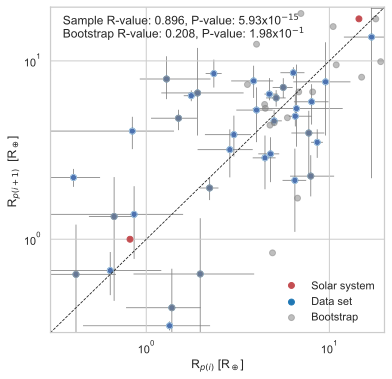

In [8]:
workingTableExoplanets = workingTableExoplanets.sort_values("star_name")

# load file either for small cool star as stated there or one of .pkl resulting from running MRD_adjacent_planets.py. 

tableEX1 =pandas.read_pickle("../data/lowMRT_mass.pkl")
## uncomment if you want to display the sub-sample
# with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(tableEX1)

resultsExoplanetsm2 = tableEX1.query("`mass-2` > `mass-1`")
resultsExoplanetsm1 = tableEX1.query("`mass-2` < `mass-1`")
resultsExoplanetsmeq = tableEX1.query("`mass-2` == `mass-1`")

mass_1 = tableEX1["mass-1"] * mass_coeff
mass_2 = tableEX1["mass-2"] * mass_coeff
star_age = tableEX1["star_age"]
star_teff = tableEX1["star_teff"]
star_mass = tableEX1["star_mass"]
star_radius = tableEX1["star_radius"]
star_metallicity = tableEX1["star_metallicity"]
star_rotp = tableEX1["st_rotp"]

print(f'Upper side of the line, planets:', len(resultsExoplanetsm2), ', part:', numpy.round(len(resultsExoplanetsm2)/ len(tableEX1), 3))
print(f'Lower side of the line, planets:', len(resultsExoplanetsm1), ', part:', numpy.round(len(resultsExoplanetsm1)/ len(tableEX1), 3))
print(f'On the line, planets:', len(resultsExoplanetsmeq))

pearson_coef, p_value = stats.pearsonr(mass_1, mass_2) #define the columns to perform calculations on

seaborn.set_theme(style="whitegrid")
plt.rcParams['figure.figsize']=(6,6)
cmap = seaborn.cubehelix_palette(rot=-.3, as_cmap=True)
g = seaborn.scatterplot(
    x=mass_1, y=mass_2,
    legend=False,
    palette=cmap
)
g.set(xscale="log", yscale="log")

g.set(ylim=(0.3, 20))
g.set(xlim=(0.3, 20))
x = numpy.linspace(0.001, 5000, 2000)
y = x
plt.plot(x, y, linewidth=0.8, linestyle='--', color='k')
xerr = numpy.nan_to_num(tableEX1[["mass_error_min-1", "mass_error_max-1"]].to_numpy().T, posinf=0.) * mass_coeff
yerr = numpy.nan_to_num(tableEX1[["mass_error_min-2", "mass_error_max-2"]].to_numpy().T, posinf=0.) * mass_coeff
def decimal(b):
    a = numpy.log10(b)
    frac1, whole1 = math.modf(a)
    b2 = whole1 - 1
    b1 = b * 10 ** abs(b2)
    return b1, b2
p_value1, p_value2 = decimal(p_value)
plt.errorbar(mass_1, mass_2, xerr=numpy.abs(xerr), yerr=numpy.abs(yerr), ls='none', fmt='0.8', ecolor='tab:gray', elinewidth=0.8, capsize=None, barsabove=True, zorder=0)
plt.scatter(mass_1, mass_2, marker="o", facecolor='tab:blue', zorder=0, label="Data set")

plt.text(0.35, 16,f"Sample R-value: {(pearson_coef).round(3)}, P-value: {p_value1.round(2)}x10$^{{{round(p_value2)}}}$", fontsize=12)
solarsystemTable = pandas.read_pickle("../data/solarsystemE.pkl")
massS = solarsystemTable["massJ"] * mass_coeff

for i in range(len(massS)-1):
    if i == 1:
        plt.plot(massS[i], massS[i+1], 'ro', ms=6, zorder=1, label="Solar system")
    else:
        plt.plot(massS[i], massS[i+1], 'ro', ms=6, zorder=1)

bootstrap = workingTableExoplanets.sample(n=40)
plt.scatter(bootstrap["mass-1"] * mass_coeff, bootstrap["mass-2"] * mass_coeff,
            facecolor ='tab:gray', alpha = 0.5, zorder=1, label="Bootstrap")

pearson_coefB, p_valueB = stats.pearsonr(bootstrap["mass-1"]* mass_coeff, bootstrap["mass-2"]* mass_coeff)

p_valueB1, p_valueB2 = decimal(p_valueB)
plt.text(0.35, 13.5,f"Bootstrap R-value: {(pearson_coefB).round(3)}, P-value: {p_valueB1.round(2)}x10$^{{{round(p_valueB2)}}}$", fontsize=12)
plt.xlabel(r"R$_{p(i)}$ [R$_\oplus$]")
plt.ylabel(r"R$_{p(i+1)}$  [R$_\oplus$] ")
plt.legend(loc="lower right", frameon=False)

plt.savefig("sample40_mass_lowMRT.png",bbox_inches="tight")
plt.savefig("sample40_mass_lowMRT.svg",bbox_inches="tight")

## Calculating the Pearson coefficients distrobutions, mean, median values from 10$^5$ error accomodation simulations for a certain sub-sample planets

Median=0.895
Median=-14.134
Meandata1=7.963491742646947e-08


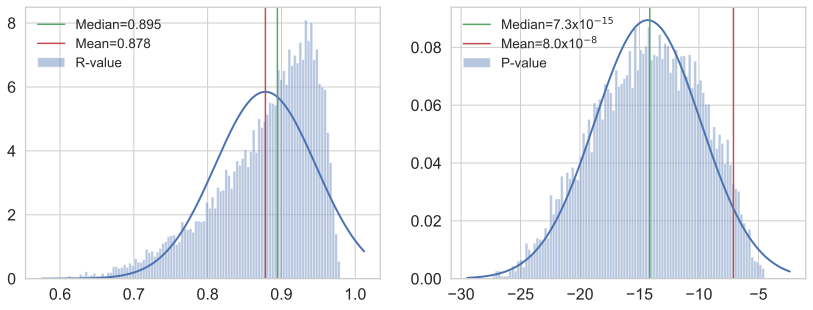

In [9]:
# load file either for small cool star as stated there or one of .pkl resulting from running MRD_adjacent_planets.py
tableEX =pandas.read_pickle("../data/lowMRT_mass.pkl")
## uncomment if you want to display the sub-sample
# with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(tableEX)

counts = 10000

mass_erD1 = numpy.zeros((len(tableEX), counts))
mass_erD2 = numpy.zeros((len(tableEX), counts))

j = 0
for index, row in tableEX.iterrows():

    massExo1 = []
    massExo2 = []
    upperLimitmass1 = (row["mass_error_max-1"] + row["mass-1"])  * mass_coeff
    lowerLimitmass1 = (row["mass-1"] - abs(row["mass_error_min-1"])) * mass_coeff
    # print(upperLimitmass1, lowerLimitmass1)
    massExo1 = numpy.random.uniform(upperLimitmass1, lowerLimitmass1, counts)
    mass_erD1[j] = massExo1

    upperLimitmass2 = (row["mass_error_max-2"] + row["mass-2"])  * mass_coeff
    lowerLimitmass2 = (row["mass-2"] - abs(row["mass_error_min-2"])) * mass_coeff
    massExo2 = numpy.random.uniform(upperLimitmass2, lowerLimitmass2, counts)
    mass_erD2[j] = massExo2
    j +=1


pearsonmassive = []
pvaluemassive = []


for i in range(counts):
    pearson_coef = 0.
    p_value = 0.
    y1 = []
    x1 = []
    for k in range(len(tableEX)):
        y1.append(mass_erD2[k][i])
        x1.append(mass_erD1[k][i])
    pearson_coef, p_value = stats.pearsonr(x1, y1)


    pearsonmassive.append(pearson_coef)
    pvaluemassive.append(p_value)

fig, ax = plt.subplots(1,2,figsize=(14,5))

data = numpy.array(pearsonmassive)

seaborn.set(rc={'figure.figsize':(14,5)})

seaborn.cubehelix_palette(start=-.2,rot=.6, as_cmap=True)
seaborn.set_theme(style="whitegrid")

h = seaborn.distplot(data, hist=True, norm_hist=True, kde=False, fit=norm, fit_kws={"color": "b", "lw": 2},bins=100, hist_kws={"weights":None, "density":True, "color": "b"}, ax=ax[0], label=f"R-value")

data1 = numpy.array(pvaluemassive)

h1 = seaborn.distplot(numpy.log10(data1), hist=True, norm_hist=True, kde=False, fit=norm, fit_kws={"color": "b", "lw": 2},bins=100, hist_kws={"weights":None, "density":True, "color": "b"}, ax=ax[1], label=f"P-value")

e = data.mean()
d = numpy.log10(data1.mean())
c=numpy.median(data)
b=numpy.log10(numpy.median(data1))

print(f"Median={c.round(3)}")
ax[0].axvline(x=c,color='g', label=f"Median={format(c,'.3f')}")
ax[0].axvline(x=e,color='r', label=f"Mean={format(e,'.3f')}")

frac1, whole1 = math.modf(b)
b2 = whole1 - 1
b1 = numpy.median(data1) * 10 ** abs(b2)
ax[1].axvline(x=b,color='g', label=f"Median={b1.round(1)}x10$^{{{round(b2)}}}$")
frac2, whole2 = math.modf(d)
d2 = whole2 - 1
d1 = data1.mean() * 10 ** abs(d2)
ax[1].axvline(x=d,color='r', label=f"Mean={d1.round(1)}x10$^{{{round(d2)}}}$")
print(f"Median={b.round(3)}")
print(f"Meandata1={data1.mean()}")

ax[0].legend(loc="upper left", prop={"size":13.5},frameon=False)
ax[1].legend(loc="upper left", prop={"size":13.5},frameon=False)
ax[0].tick_params(axis='both', which='major', labelsize=16)

ax[1].tick_params(axis='both', which='major', labelsize=16)

plt.savefig("Star_chunks_Pearson_dist_mass.png",bbox_inches="tight")
plt.savefig("Star_chunks_Pearson_dist_mass.svg",bbox_inches="tight")
#
# plt.savefig("Star_chunks_Pearson_dist_masslow.png",bbox_inches="tight")
# plt.savefig("Star_chunks_Pearson_dist_masslow.svg",bbox_inches="tight")

Pearson Correlation Coefficient for data:  0.8957804789426222 and a P-value of: 5.934163141195701e-15
R-value median for Bootstrap: 0.008679246340690025
P-value median for Bootstrap: 0.820368067522681


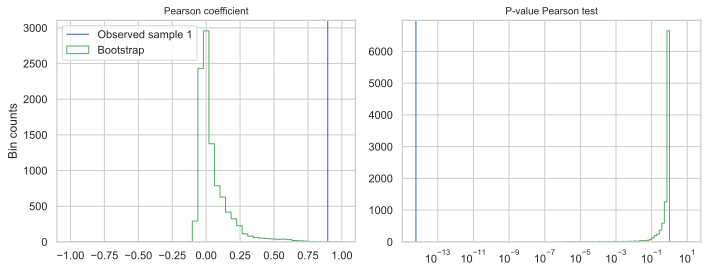

In [10]:
chunk_data = pandas.read_pickle("../data/lowMRT_mass.pkl")
mass_chunk1 = chunk_data["mass-1"] * mass_coeff
mass_chunk2 = chunk_data["mass-2"] * mass_coeff

pearson_coef1, p_value1 = stats.pearsonr(mass_chunk1, mass_chunk2)
print("Pearson Correlation Coefficient for data: ", pearson_coef1, "and a P-value of:", p_value1) # Results

## if you have another unusual correlated sub-sumple, uncomment below and load one of .pkl resulting from running MRD_adjacent_planets.py
# chunk_data1 = pandas.read_pickle("../data/0_0.9031842203261989_star_teff_mass.pkl")
# with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(chunk_data1.sort_values("star_age"))
# mass_chunk11 = chunk_data1["mass-1"] * mass_coeff
# mass_chunk12 = chunk_data1["mass-2"] * mass_coeff
# pearson_coef2, p_value2 = stats.pearsonr(mass_chunk11, mass_chunk12)
# print("Pearson Correlation Coefficient for data: ", pearson_coef2, "and a P-value of:", p_value2) # Results

Pearson = []
PvalPe = []

for i in range(10000):
    pearson_coef = 0.
    p_value = 0.

    newtable =  workingTableExoplanets.sample(n=40)



    mass_1 = newtable["mass-1"] * mass_coeff
    mass_2 = newtable["mass-2"] * mass_coeff


    pearson_coef, p_value = stats.pearsonr(mass_1, mass_2)

    Pearson.append(pearson_coef)
    PvalPe.append(p_value)


fig, ax = plt.subplots(1, 2, figsize=(10,4))

a = numpy.linspace(-1,1,50)
c = numpy.linspace(0,1,50)

b = numpy.logspace(-6,1,50)
# ax.axvline(10, 0,1)
ax[0].hist(Pearson, bins = a, histtype='step', color='g',label="Bootstrap")
print(f"R-value median for Bootstrap: {numpy.median(Pearson)}")
ax[0].axvline(pearson_coef1,color="b", linewidth=1.1, label="Observed sample 1")
# # uncomment the line below if you have another sub-sample
# ax[0].axvline(pearson_coef2,color="orange", linewidth=1.1, label="Observed sample 2")

ax[0].set_title(r'Pearson coefficient', fontsize=10)
ax[0].set_ylabel('Bin counts')

ax[1].hist(PvalPe, bins = b, histtype='step', color='g')
print(f"P-value median for Bootstrap: {numpy.median(PvalPe)}")

ax[1].axvline(p_value1,color="b", linewidth=1.1)
# # uncomment the line below if you have another sub-sample
# ax[1].axvline(p_value2,color="orange", linewidth=1.1)

ax[1].set_title(r'P-value Pearson test', fontsize=10)
ax[1].set_xscale('log')

ax[0].legend()
plt.tight_layout()
plt.savefig("rad_40_bootstrap_histR.png",bbox_inches="tight")
plt.savefig("rad_40_bootstrap_histR.svg",bbox_inches="tight")